In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
# %qtconsole

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import seaborn as sns

from dask.distributed import Client, LocalCluster
import dask
import logging

logging.basicConfig(level=logging.INFO)

client = Client(processes=True, n_workers=14, threads_per_worker=1, memory_limit='25GB')

client

Client Scheduler: tcp://127.0.0.1:39142 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 14 Cores: 14 Memory: 350.00 GB


In [3]:
from src.load_data import load_data

epoch_key = ('bon', 5, 2)

data = load_data(epoch_key)

INFO:src.load_data:Finding ripple times...


In [4]:
from src.parameters import replay_speed, place_bin_size, movement_var, discrete_diag
from replay_trajectory_classification import SortedSpikesClassifier

position = data['position_info'].linear_position
track_labels = data['position_info'].arm_name
ripple_times = data['ripple_times'].loc[:, ['start_time', 'end_time']]

continuous_transition_types = (
    [['w_track_1D_random_walk', 'uniform', 'identity'],
     ['uniform',   'uniform', 'uniform'],
     ['w_track_1D_random_walk', 'uniform', 'identity']])

classifier = SortedSpikesClassifier(
    place_bin_size=1, movement_var=1,
    replay_speed=1,
    discrete_transition_diag=discrete_diag,
    spike_model_penalty=0.5, knot_spacing=5,
    continuous_transition_types=continuous_transition_types).fit(
    position, data['spikes'], track_labels=track_labels)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


In [ ]:
results = classifier.predict(data['spikes'], time=data['position_info'].index).drop(['likelihood', 'causal_posterior'])

In [12]:
results

<xarray.Dataset>
Dimensions:            (position: 363, state: 3, time: 460499)
Coordinates:
  * time               (time) timedelta64[ns] 00:37:31.006200 ... 00:52:52.002200
  * position           (position) float64 -0.4996 0.4996 1.499 ... 360.2 361.2
  * state              (state) <U22 'w_track_1D_random_walk' ... 'identity'
Data variables:
    acausal_posterior  (time, state, position) float64 0.0 ... 6.894e-05

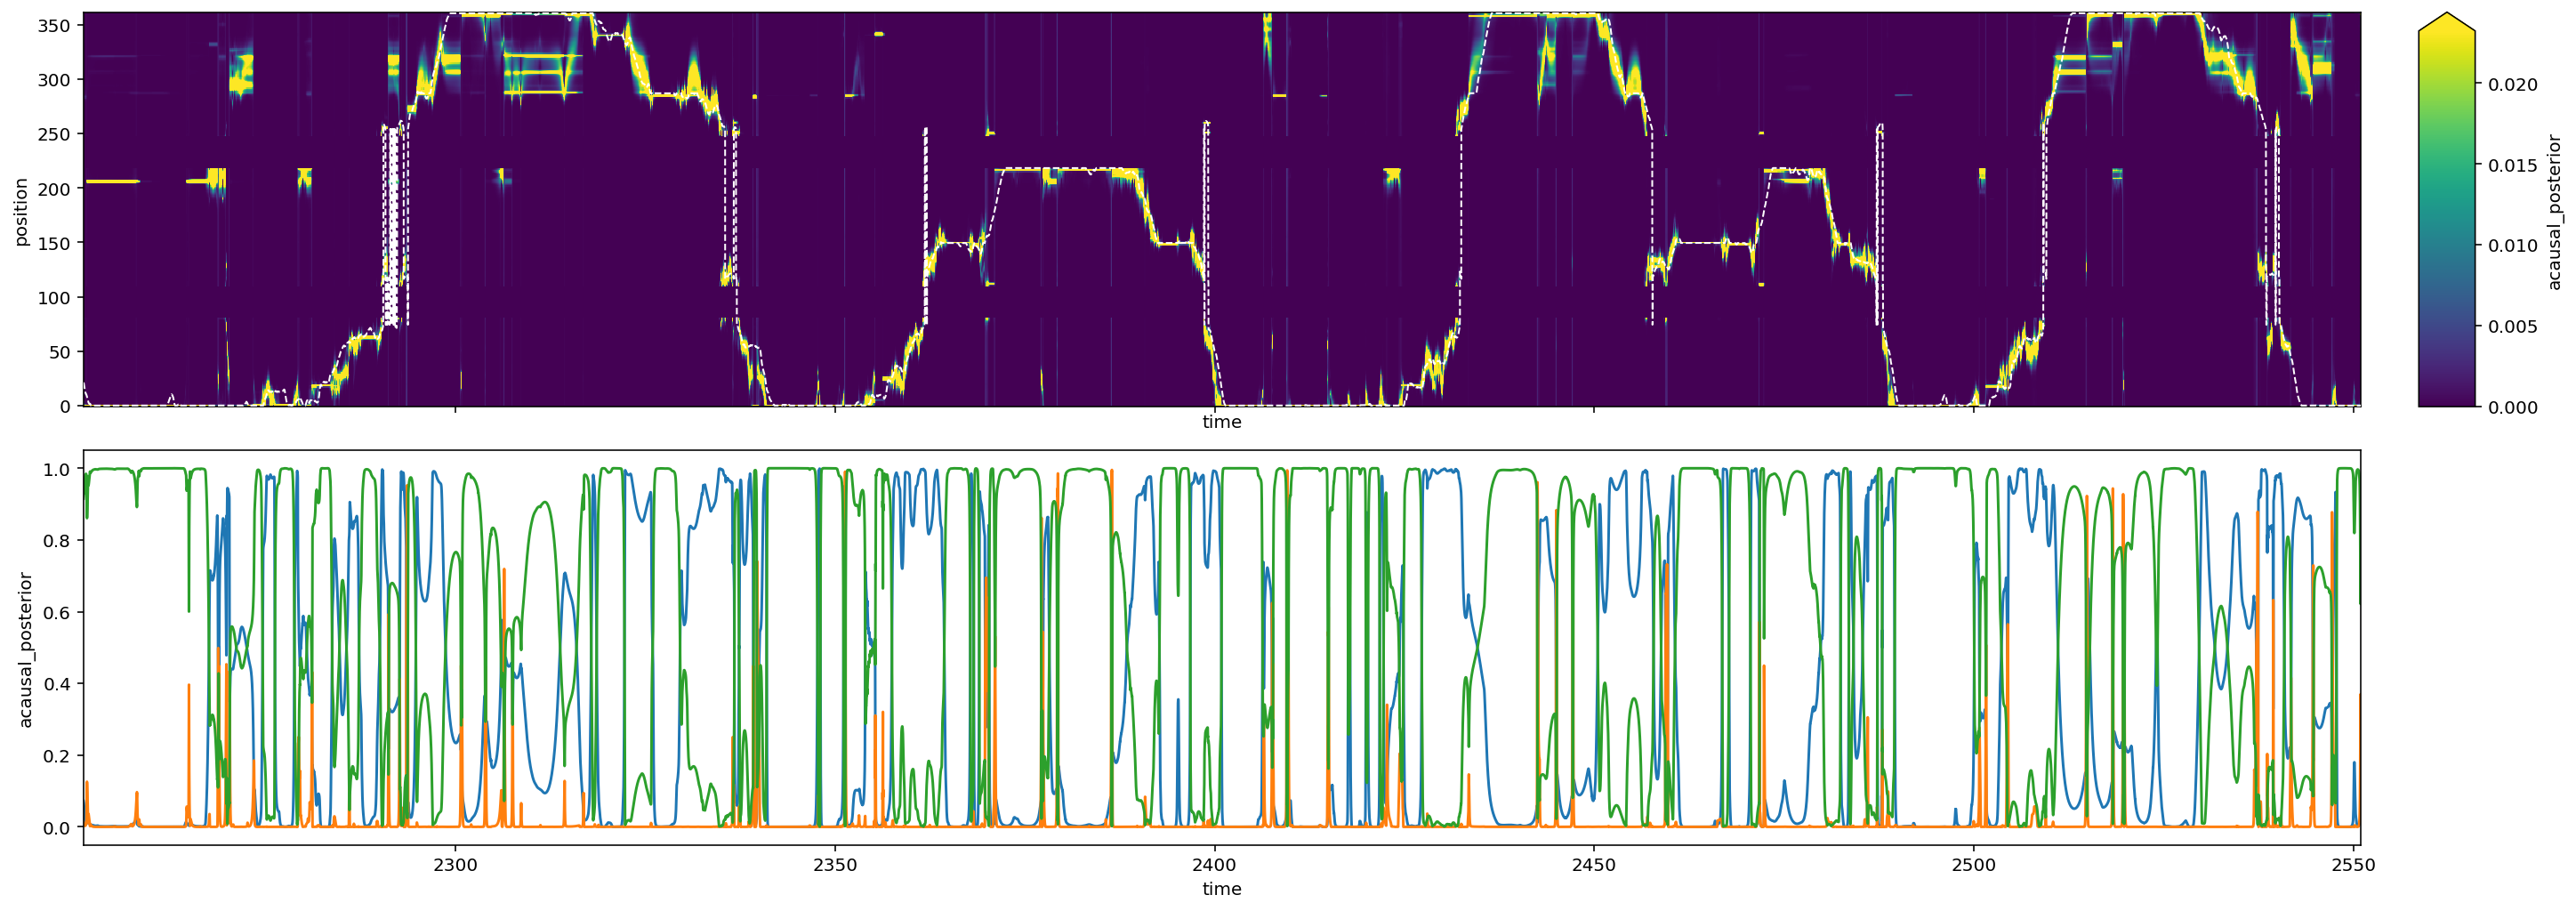

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(20, 7), sharex=True, constrained_layout=True)

time_slice = slice(0, 150_000)

(results
 .acausal_posterior
 .sum('state')
 .isel(time=time_slice)
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
 .plot(x='time', y='position', robust=True, ax=axes[0])
)

axes[0].plot(data['position_info'].iloc[time_slice].index.total_seconds().values,
             data['position_info'].iloc[time_slice].linear_position.values,
             color='white', linestyle='--', linewidth=1, zorder=10)

(results
 .acausal_posterior
 .sum('position')
 .isel(time=time_slice)
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
 .plot(x='time', hue='state', ax=axes[1], add_legend=False)
);

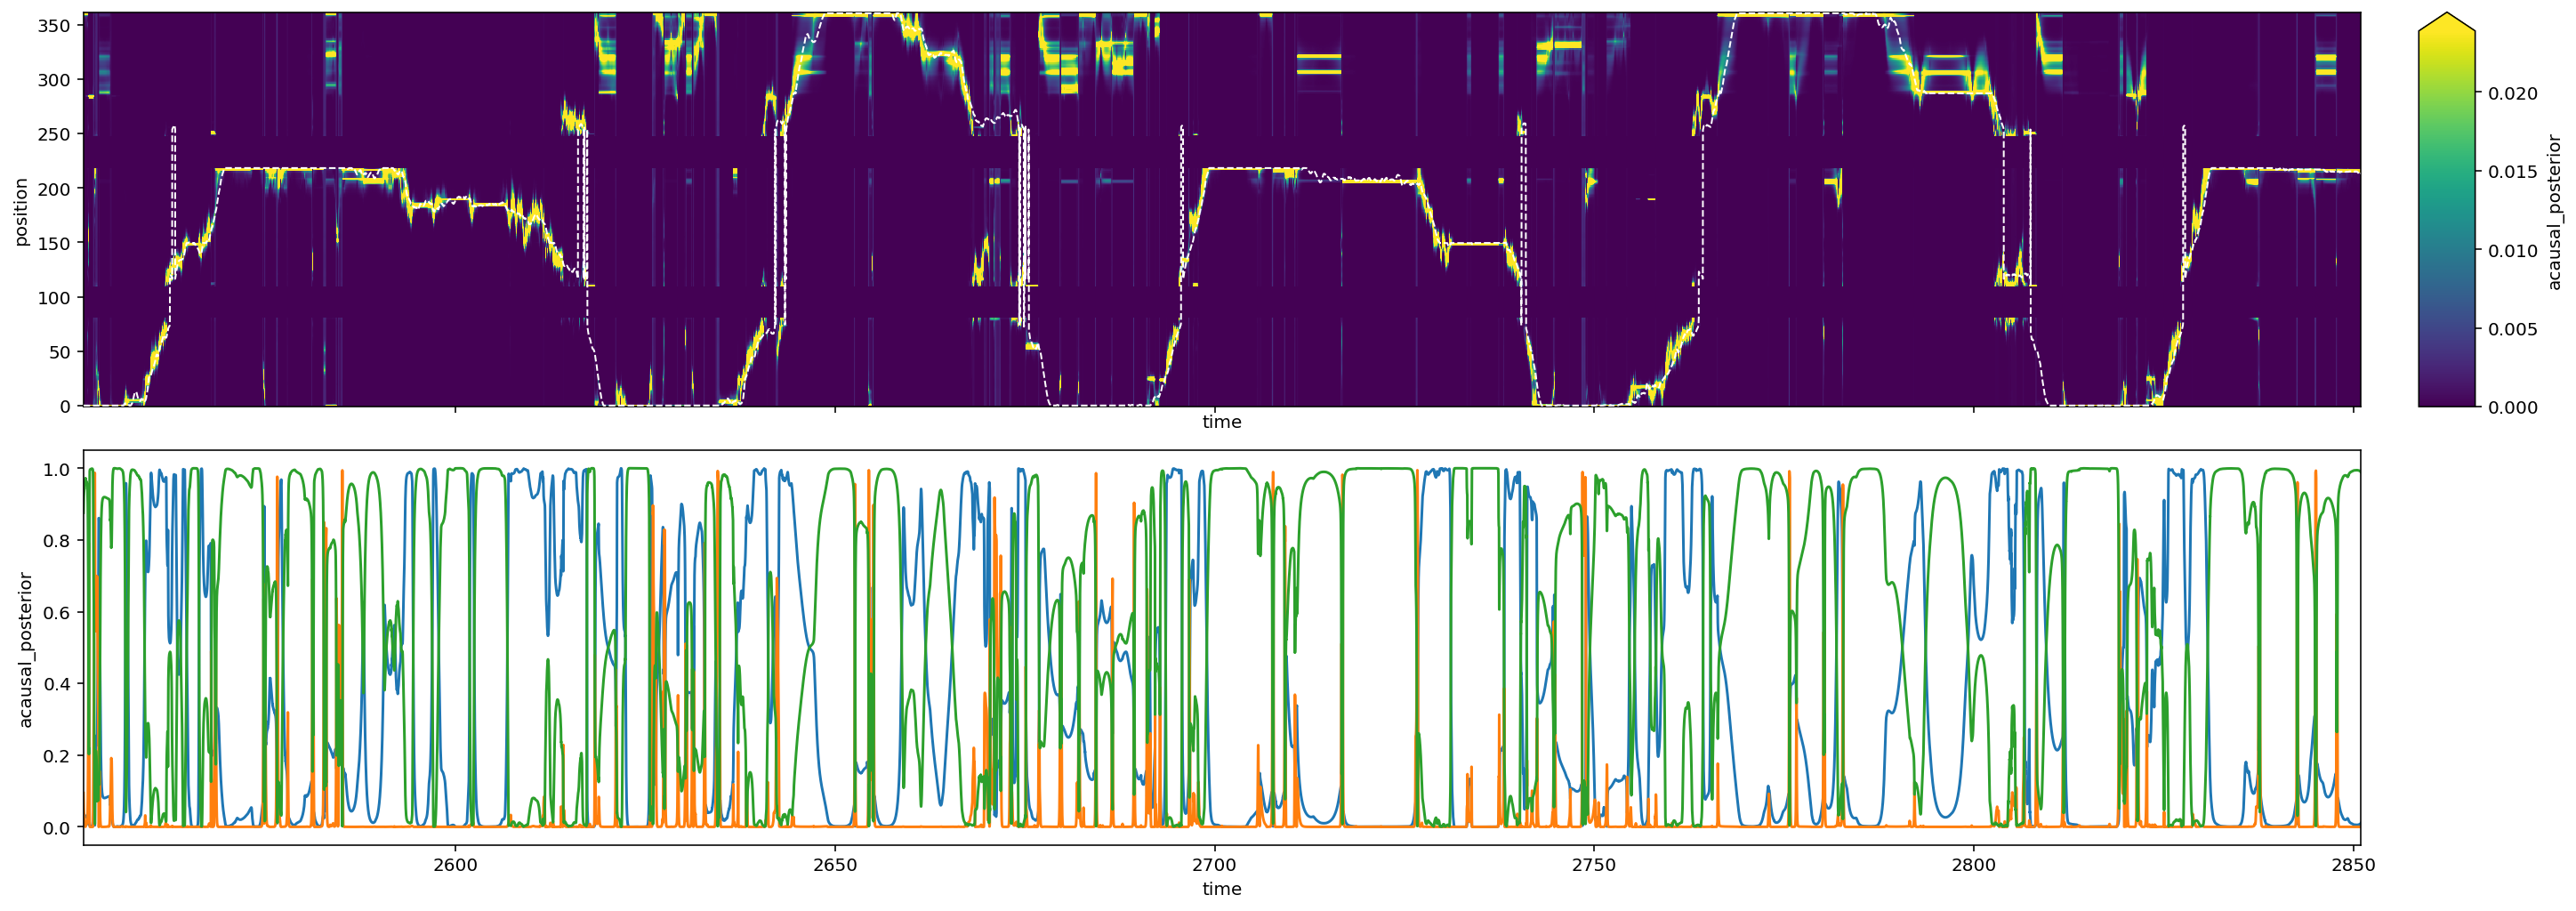

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(20, 7), sharex=True, constrained_layout=True)

time_slice = slice(150_000, 300_000)

(results
 .acausal_posterior
 .sum('state')
 .isel(time=time_slice)
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
 .plot(x='time', y='position', robust=True, ax=axes[0])
)

axes[0].plot(data['position_info'].iloc[time_slice].index.total_seconds().values,
             data['position_info'].iloc[time_slice].linear_position.values,
             color='white', linestyle='--', linewidth=1, zorder=10)

(results
 .acausal_posterior
 .sum('position')
 .isel(time=time_slice)
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
 .plot(x='time', hue='state', ax=axes[1], add_legend=False)
);

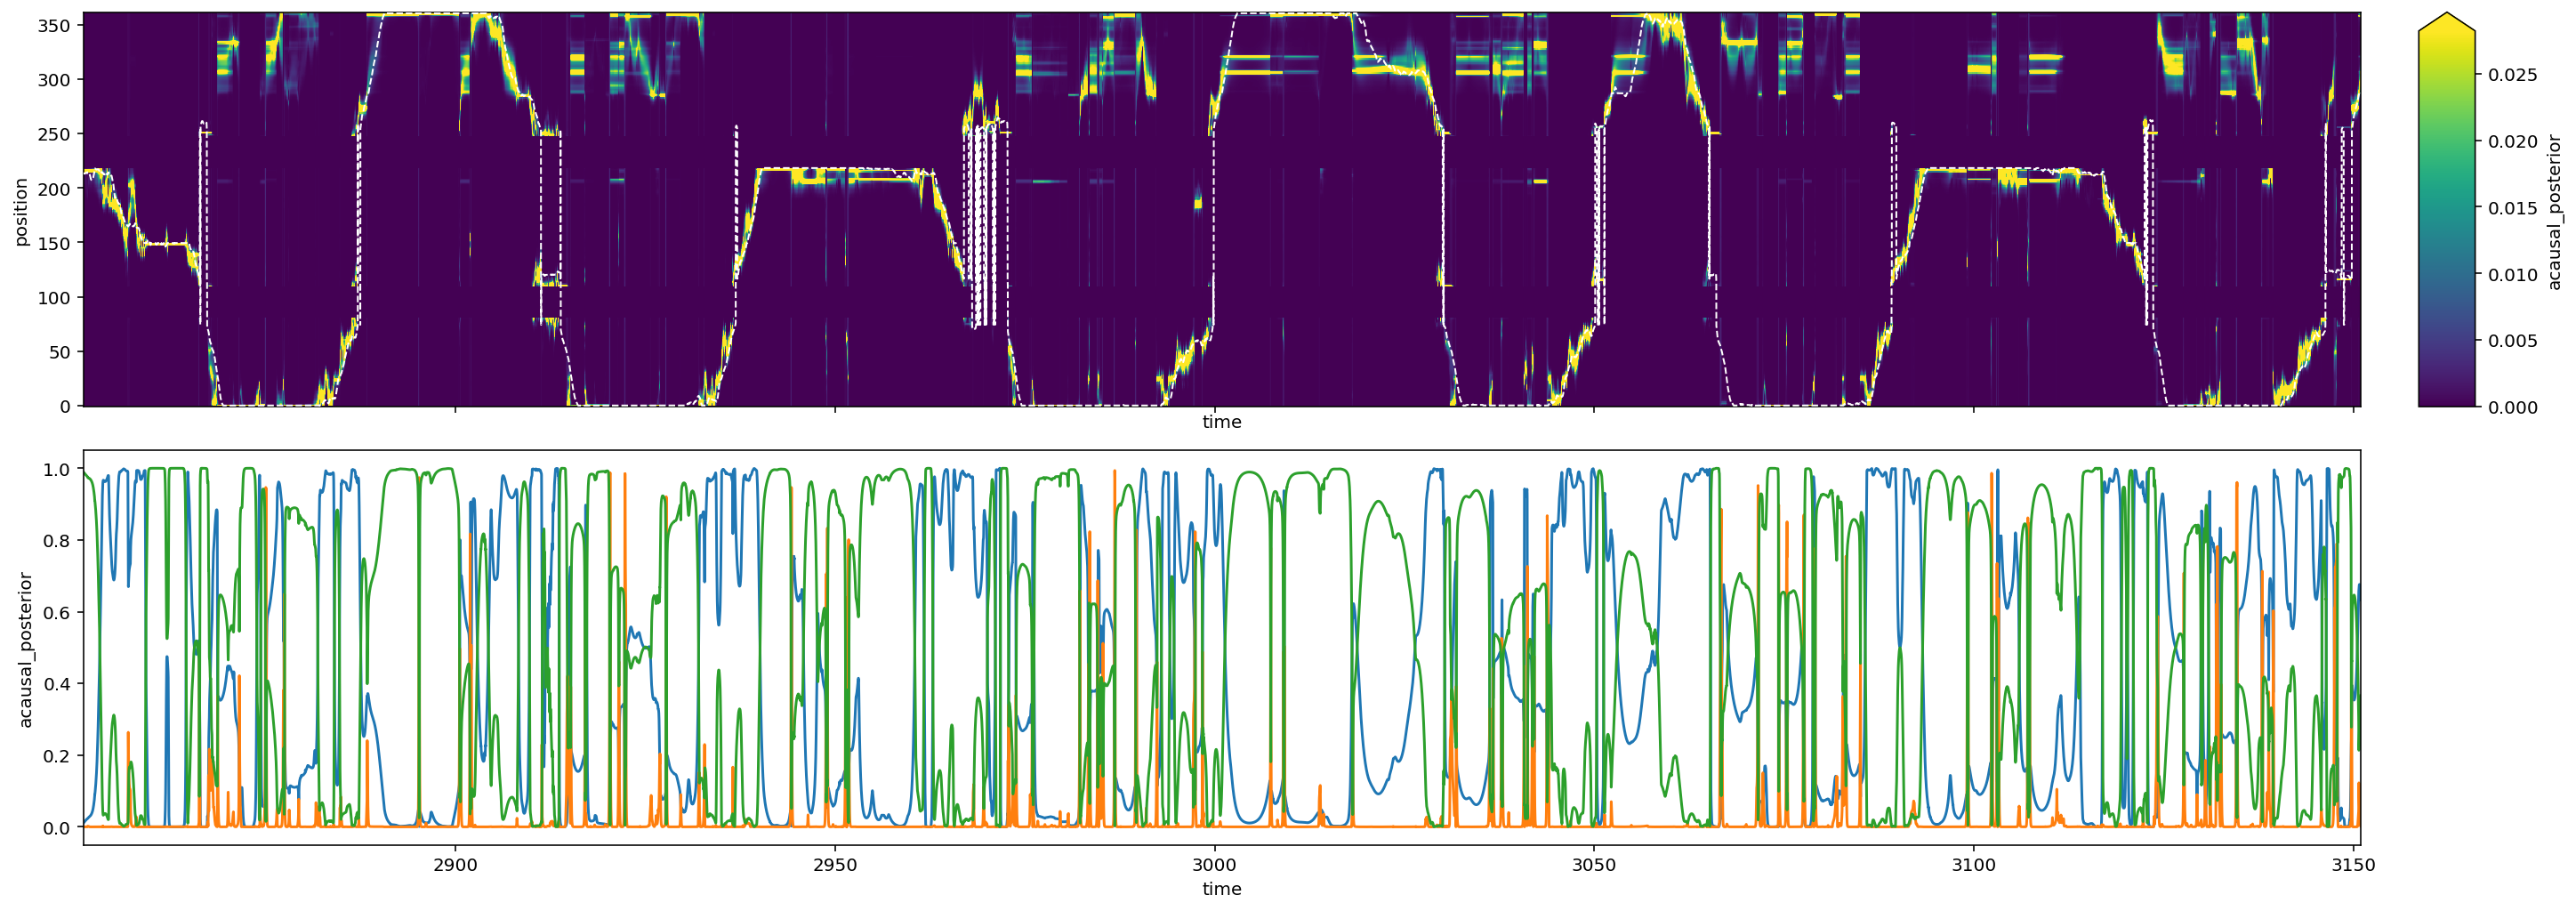

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(20, 7), sharex=True, constrained_layout=True)

time_slice = slice(300_000, 450_000)

(results
 .acausal_posterior
 .sum('state')
 .isel(time=time_slice)
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
 .plot(x='time', y='position', robust=True, ax=axes[0])
)

axes[0].plot(data['position_info'].iloc[time_slice].index.total_seconds().values,
             data['position_info'].iloc[time_slice].linear_position.values,
             color='white', linestyle='--', linewidth=1, zorder=10)

(results
 .acausal_posterior
 .sum('position')
 .isel(time=time_slice)
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
 .plot(x='time', hue='state', ax=axes[1], add_legend=False)
);

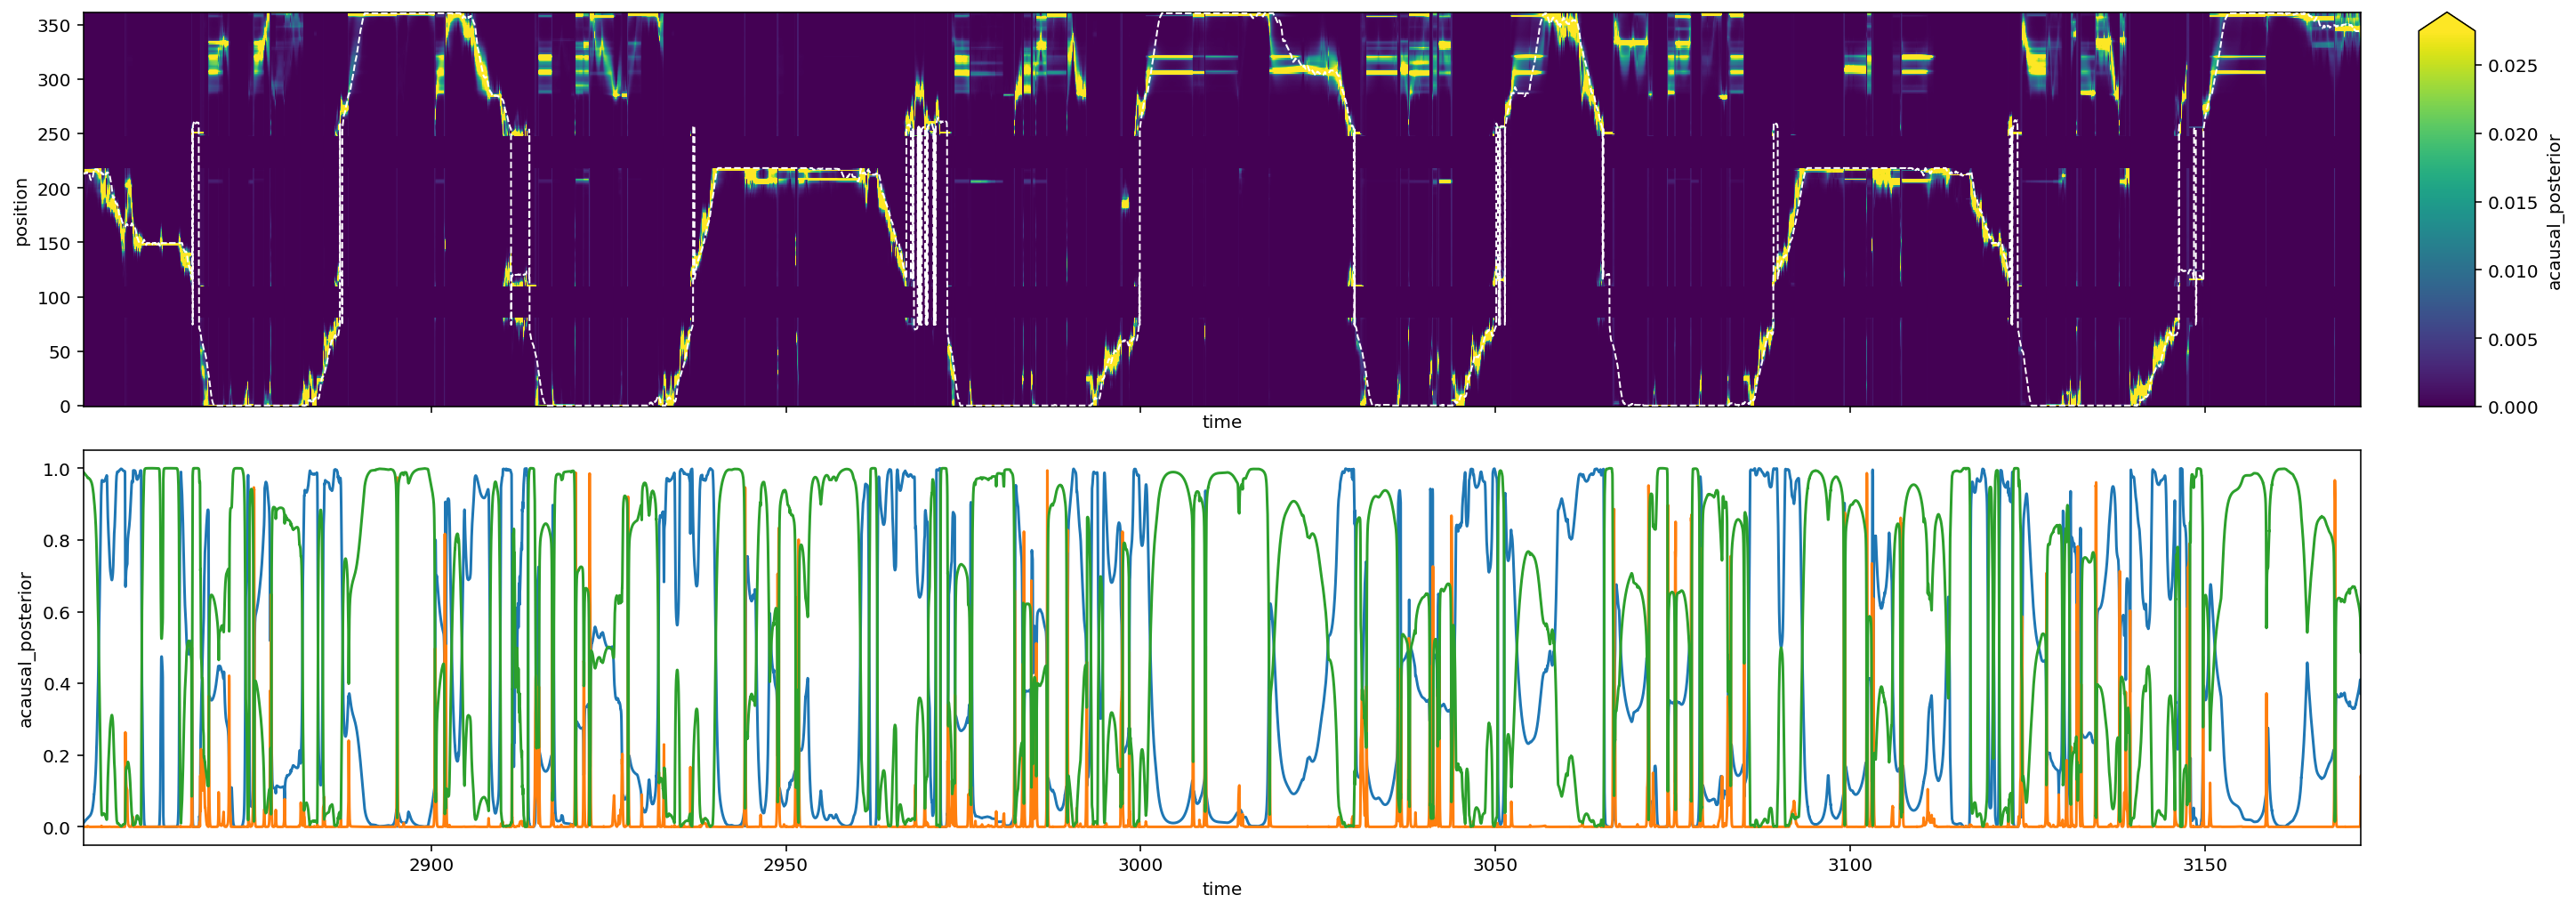

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(20, 7), sharex=True, constrained_layout=True)

time_slice = slice(300_000, 465_498)

(results
 .acausal_posterior
 .sum('state')
 .isel(time=time_slice)
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
 .plot(x='time', y='position', robust=True, ax=axes[0])
)

axes[0].plot(data['position_info'].iloc[time_slice].index.total_seconds().values,
             data['position_info'].iloc[time_slice].linear_position.values,
             color='white', linestyle='--', linewidth=1, zorder=10)

(results
 .acausal_posterior
 .sum('position')
 .isel(time=time_slice)
 .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's'))
 .plot(x='time', hue='state', ax=axes[1], add_legend=False)
);

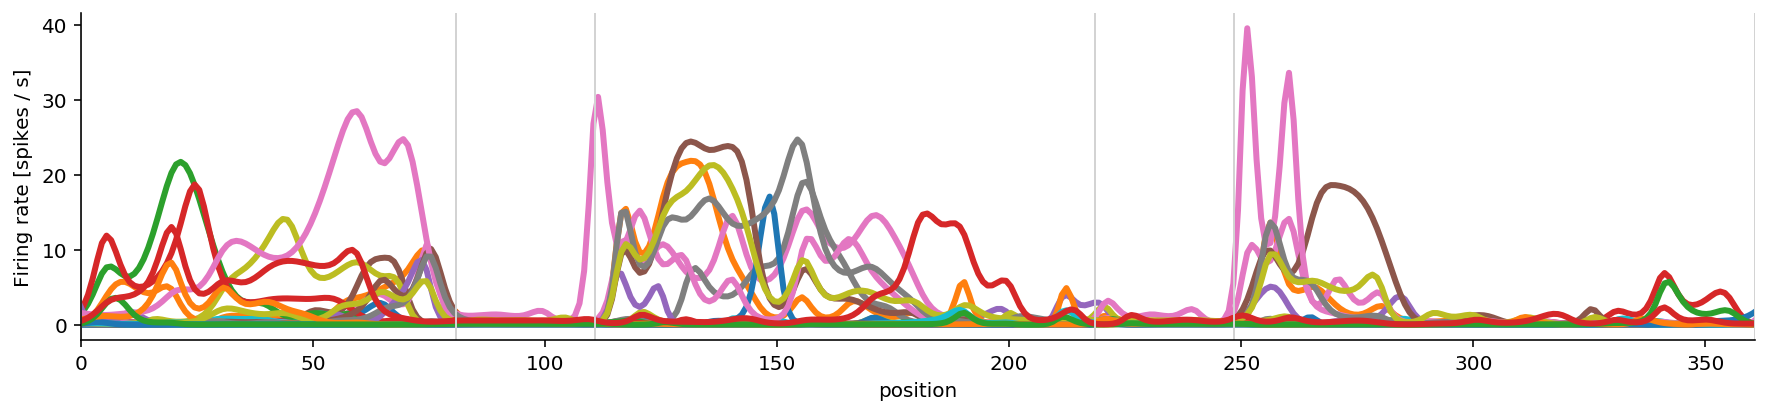

In [17]:
(classifier.place_fields_ * 500).plot(x='position', hue='neuron', size=3, aspect=5, add_legend=False, linewidth=3)
plt.xlim((0, data['position_info'].linear_position.max()))
max_df = data['position_info'].groupby('arm_name').linear_position.max()
min_df = data['position_info'].groupby('arm_name').linear_position.min()

for arm_name, max_position in max_df.iteritems():
    plt.axvline(max_position, color='lightgrey',
                    linestyle='-', linewidth=1)
for arm_name, min_position in min_df.iteritems():
    plt.axvline(min_position, color='lightgrey',
                    linestyle='-', linewidth=1)
plt.ylabel('Firing rate [spikes / s]')
sns.despine()